In [53]:
# read in libraries
import sys, os
import netCDF4
import scipy.io, numpy
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy import interpolate
import matplotlib.patches as mpatches

In [1129]:
directory = '/Users/evenhou/Downloads/armdata'
# kappa_50 = pd.Series() # array, for all kappa in all file with size = 50 nm
# conc_norm1_50 = pd.Series() # array, for all normalized conc in all file with size = 50 nm
# #volume fraction at bin i
# p_LH_i = pd.Series()
# p_MH_i = pd.Series()
kappa_LH = 0.01
kappa_MH = 0.65

chi50 = np.array([]) 
chi100 = np.array([])
chi150 = np.array([])
chi200 = np.array([])
chi250 = np.array([])

for subdir, dirs, files in os.walk(directory):
    for file in files:
        filename = subdir + os.sep + file
        if ('sgpaoshtdmaE13.b1.20220916' in filename) and ('.nc' in filename):
# =============== FOR EACH FILE ===============
# get dimensions of time and bins
            ds = netCDF4.Dataset(filename)
            s1 = str(ds.dimensions['time'])
            s2 = str(ds.dimensions['bin'])
            # print(s)
            x = -3
            if (s1[x-1:x+1] != '='):
                dim_time = int(s1[x:])
            else:
                dim_time = int(s1[x-1:])
            if (s2[x-1:x+1] != '='):
                dim_bin = int(s2[x:])
            else:
                dim_bin = int(s2[x-1:])
            # print(dim_time, dim_bin)
            print(filename)
# CHANGE HERE: define arrays
            time = np.zeros(dim_time)
            dry_dia = np.zeros(dim_time)
            kappa = np.zeros((dim_time, dim_bin))
            k_bound = np.zeros((dim_time, dim_bin,2))
            conc = np.zeros((dim_time, dim_bin))
            # date = np.zeros(dim_time)
            
# CHANGE HERE: read data into arrays
            ncf = scipy.io.netcdf_file(filename, mmap=False)
            date = int(filename[-18:-10]) # read i.e. 20210427
           
            time[:] = ncf.variables["time"].data/3600 # hr
            dry_dia[:] = ncf.variables["dry_diameter_setting"].data # nm
            for i_time in range(dim_time):
                kappa[i_time, :] = ncf.variables['kappa'][i_time, :]
                k_bound[i_time, :, :] = ncf.variables['kappa_bounds'][i_time, :, :]
                conc[i_time,:] = ncf.variables['aerosol_concentration'][i_time, :] # dN, unit: 1/cm^3
            # print(dry_dia)
            # print(k_bound)

# calculations
            dK = np.zeros((dim_time,dim_bin))
            for i_time in range(dim_time):
                dK[i_time, :] = k_bound[i_time, :, 1] -  k_bound[i_time, :, 0]
            conc_norm0 = np.zeros((dim_time,dim_bin)) # dN/dK
            for i_time in range(dim_time):
                conc_norm0[i_time, :] = conc[i_time, :]/dK[i_time, :]
            
# Create a mask for valid kappa values
            valid_kappa_mask = (kappa >= kappa_LH) & (kappa <= kappa_MH)



/Users/evenhou/Downloads/armdata/sgpaoshtdmaE13.b1.20220916.000500.nc


In [1130]:
conc

array([[0.00000000e+00, 0.00000000e+00, 4.34999990e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 5.94000006e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 9.99999978e-03, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [0.00000000e+00, 0.00000000e+00, 3.99999991e-02, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 9.49999988e-01, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 1.12500000e+01, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

In [1131]:
np.average(conc,axis=1)

array([8.06063334e+01, 4.81311665e+01, 2.94627665e+02, 2.97205668e+02,
       1.31235500e+02, 1.39046500e+02, 1.29534833e+02, 2.85152833e+02,
       2.27214330e+02, 1.46446500e+02, 1.59804501e+02, 8.57723334e+01,
       1.62296000e+02, 2.07898000e+02, 9.39556654e+01, 5.42738333e+01,
       4.91158338e+01, 2.24378837e+02, 2.57524666e+02, 3.24628331e+02,
       1.58197167e+02, 1.03416166e+02, 3.43589335e+02, 4.13324667e+02,
       1.64040165e+02, 5.14376669e+01, 5.89139998e+01, 2.73345666e+02,
       2.49461499e+02, 1.39556333e+02, 1.18565666e+02, 8.38131665e+01,
       1.56623168e+02, 1.83698664e+02, 1.07454000e+02, 5.84235005e+01,
       6.88690002e+01, 2.14323997e+02, 2.90012498e+02, 1.95068669e+02,
       5.45443332e+01, 1.13905500e+02, 2.88357997e+02, 1.74539503e+02,
       6.22421676e+01, 4.39838331e+01, 9.14463341e+01, 2.73382499e+02,
       2.96789003e+02, 1.77003166e+02, 1.29406500e+02, 2.14149000e+02,
       4.61474498e+02, 4.91846335e+02, 2.56091168e+02, 1.60192000e+02,
      

In [1132]:
valid_kappa_mask

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [1133]:
# Create a color map where invalid kappa values are green and valid values are yellow
colors = np.full_like(kappa, 1)  # 0 for green, 1 for yellow
colors[valid_kappa_mask] = 0

In [1134]:
date_str = f"{date:8}"  # Convert to string for formatting
formatted_date = f"{date_str[0:4]}-{date_str[4:6]}-{date_str[6:8]}"  # YYYY-MM-DD

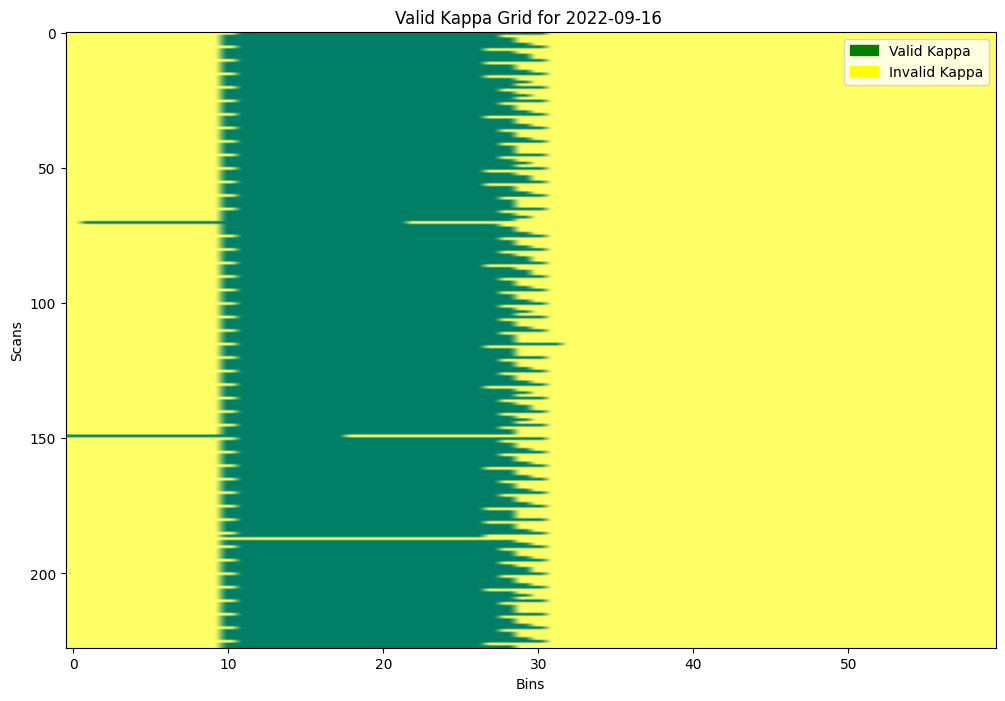

In [1135]:
# Plot the valid kappa grid
plt.figure(figsize=(12, 8))
plt.imshow(colors, cmap='summer', aspect='auto')
plt.title(f'Valid Kappa Grid for {formatted_date} ')
plt.xlabel('Bins')
plt.ylabel('Scans')

# Create legend patches
green_patch = mpatches.Patch(color='green', label='Valid Kappa')
yellow_patch = mpatches.Patch(color='yellow', label='Invalid Kappa')
plt.legend(handles=[green_patch, yellow_patch], loc='upper right')

plt.show()

In [1136]:
kappa[:,10:20]

array([[0.00557835, 0.01894657, 0.03331666, ..., 0.12304822, 0.14532143,
        0.16929686],
       [0.02671701, 0.04601636, 0.06672353, ..., 0.19455543, 0.22603247,
        0.25997546],
       [0.01672978, 0.03300261, 0.05046694, ..., 0.15991382, 0.18711583,
        0.21644452],
       ...,
       [0.00553742, 0.01880739, 0.03304742, ..., 0.12210882, 0.14421488,
        0.1680104 ],
       [0.02693403, 0.04639184, 0.0672704 , ..., 0.19618377, 0.22793178,
        0.26216856],
       [0.01672624, 0.03299562, 0.05052513, ..., 0.15987948, 0.18707556,
        0.21639785]])

In [1137]:
valid_kappa_mask[:,10:20]

array([[False,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [False,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

In [1138]:
conc[:,5:10]

array([[0.00000000e+00, 1.09999999e-01, 2.35999990e+00, 1.81399994e+01,
        2.76499996e+01],
       [4.84700012e+01, 7.56500015e+01, 1.22440002e+02, 9.88600006e+01,
        3.64900017e+01],
       [1.15600004e+01, 2.03299999e+01, 1.34799995e+01, 2.04200001e+01,
        8.42200012e+01],
       ...,
       [7.34000015e+00, 1.86000001e+00, 5.65999985e+00, 2.33899994e+01,
        4.50600014e+01],
       [1.41999998e+01, 3.25900002e+01, 6.18699989e+01, 8.65800018e+01,
        1.19010002e+02],
       [3.06599998e+01, 5.01699982e+01, 3.80900002e+01, 4.85699997e+01,
        9.28600006e+01]])

In [1139]:
# Update conc matrix for invalid kappa values
conc[~valid_kappa_mask] = 0

In [1140]:
conc[:,5:10]

array([[0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.]])

In [1141]:
N_tot = conc.sum(axis=1)

In [1142]:
# Check if there is 0 value in N_tot
has_zero = np.any(N_tot == 0)
print(has_zero)
# Find indices of zero values
zero_indices = np.where(N_tot == 0)
print(zero_indices)

True
(array([187]),)


In [1143]:
# use pandas to manipulate data
d = {'dry_dia': dry_dia, 'time':time, 'date':date, 'N_tot':N_tot}
df = pd.DataFrame(data = d)

In [1144]:
conc_norm = np.zeros((dim_time,dim_bin))
for i_time in range(dim_time):
    conc_norm[i_time, :] = conc_norm0[i_time, :]/N_tot[i_time]
# print(conc_norm)
# # conc_norm0[66]
# print("conc_norm[66,:]:", conc_norm[66,:])
# print("N_tot[66]:", N_tot[66])
# print("conc_norm0[66,:]:", conc_norm0[66,:])

/var/folders/n8/bjc7cpvs3hnd3g97l3ky6q4w0000gn/T/ipykernel_96104/166567296.py:3: RuntimeWarning: divide by zero encountered in divide
  conc_norm[i_time, :] = conc_norm0[i_time, :]/N_tot[i_time]
/var/folders/n8/bjc7cpvs3hnd3g97l3ky6q4w0000gn/T/ipykernel_96104/166567296.py:3: RuntimeWarning: invalid value encountered in divide
  conc_norm[i_time, :] = conc_norm0[i_time, :]/N_tot[i_time]


In [1145]:

newdf = pd.DataFrame(np.repeat(df.values, dim_bin, axis=0),
                        columns=df.columns)
# print(dim_bin)
#print(newdf.shape)
newdf['kappa'] = kappa.ravel() # K_i
newdf['conc'] = conc.ravel()
newdf['dK'] = dK.ravel()
newdf['conc_norm0'] = conc_norm0.ravel()  # dN/dK


In [1146]:
rows_with_nan = np.where(np.isnan(conc_norm).any(axis=1))[0]
print("rows_with_nan",rows_with_nan)

dNdK0 = np.array([])
# Remove corresponding rows from both conc_norm, kappa, and dry_dia
conc_norm_clean = np.delete(conc_norm, rows_with_nan, axis=0)
kappa_clean = np.delete(kappa, rows_with_nan, axis=0)
dry_dia_clean = np.delete(dry_dia, rows_with_nan, axis=0)
time_clean = np.delete(time, rows_with_nan, axis=0)
dNdK0 = np.append(dNdK0,conc_norm_clean)

rows_with_nan [187]


In [1147]:
xnew = np.linspace(0, 1.3, 30) # K0
df_k = pd.DataFrame(columns=['dia', 'K0', 'dNdK'])

new_time = len(conc_norm_clean)
dNdK = np.zeros((new_time,30))
for i_time in range(new_time):
# i_time = 1
    # dia = dry_dia[i_time]
    x = kappa_clean[i_time,:] # one scan:kappa
    y = conc_norm_clean[i_time,:] # one scan: c(k)
    f = interpolate.interp1d(x,y,kind = 'nearest', fill_value= "extrapolate")
    ynew = f(xnew)
    dNdK[i_time,:] = ynew
dia = np.repeat(dry_dia_clean, 30) # for one scan
t = np.repeat(time_clean,30)
x_flat = np.tile(xnew, new_time) # for different bin

y_flat = dNdK.ravel()

temp_df = pd.DataFrame({'time': t,'dia': dia,'K0': x_flat,'dNdK': y_flat})
df_k = pd.concat([df_k, temp_df], ignore_index=True)
print(df_k)

        dia        K0      dNdK       time
0     250.0  0.000000  0.304171   0.083333
1     250.0  0.044828  1.365537   0.083333
2     250.0  0.089655  2.044622   0.083333
3     250.0  0.134483  5.831827   0.083333
4     250.0  0.179310  6.385959   0.083333
...     ...       ...       ...        ...
6805  100.0  1.120690  0.000000  23.979167
6806  100.0  1.165517  0.000000  23.979167
6807  100.0  1.210345  0.000000  23.979167
6808  100.0  1.255172  0.000000  23.979167
6809  100.0  1.300000  0.000000  23.979167

[6810 rows x 4 columns]


/var/folders/n8/bjc7cpvs3hnd3g97l3ky6q4w0000gn/T/ipykernel_96104/311700172.py:21: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_k = pd.concat([df_k, temp_df], ignore_index=True)


In [1148]:
newdf_50 = newdf[newdf['dry_dia'] == 50]
newdf_100 = newdf[newdf['dry_dia'] == 100]
newdf_150 = newdf[newdf['dry_dia'] == 150]
newdf_200 = newdf[newdf['dry_dia'] == 200]
newdf_250 = newdf[newdf['dry_dia'] == 250]

Text(0.5, 1.0, 'κ-PDF for 200 nm aerosols on 2022-09-16')

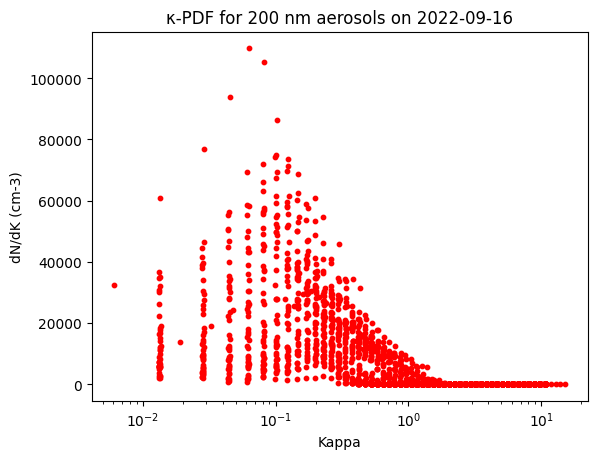

In [1149]:
plt.scatter(newdf_200.kappa,newdf_200.conc_norm0,s=10,c='r')  # s => size, c => color
plt.xlabel("Kappa")
plt.ylabel("dN/dK (cm-3)")
plt.xscale('log')
plt.title(f"κ-PDF for 200 nm aerosols on {formatted_date}")

In [1150]:
newdf['conc_norm'] = newdf['conc_norm0']/newdf['N_tot'] # dN°/dK = c(k)_i
newdf['p_MH_i'] = (newdf.kappa-kappa_LH)/(kappa_MH-kappa_LH)
newdf['p_LH_i'] = 1 - newdf['p_MH_i']

newdf.loc[newdf['N_tot'] == 0, 'p_MH_i'] = 0
newdf.loc[newdf['kappa'] < kappa_LH, 'p_MH_i'] = 0
newdf.loc[newdf['kappa'] > kappa_MH, 'p_MH_i'] = 0

newdf.loc[newdf['N_tot'] == 0, 'p_LH_i'] = 0
newdf.loc[newdf['kappa'] < kappa_LH, 'p_LH_i'] = 0
newdf.loc[newdf['kappa'] > kappa_MH, 'p_LH_i'] = 0

newdf['H_i'] = -newdf.p_LH_i*np.log(newdf.p_LH_i)-newdf.p_MH_i*np.log(newdf.p_MH_i)
newdf['H_alpha_i'] = newdf.H_i*newdf.conc_norm*newdf.dK
newdf['p_mh_i'] = newdf.p_MH_i*newdf.conc_norm*newdf.dK
newdf['p_lh_i'] = newdf.p_LH_i*newdf.conc_norm*newdf.dK

newdf.loc[newdf['N_tot'] == 0, 'H_alpha_i'] = 0
newdf.loc[newdf['kappa'] < kappa_LH, 'H_alpha_i'] = 0
newdf.loc[newdf['kappa'] > kappa_MH, 'H_alpha_i'] = 0

# print("newdf",newdf)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [1151]:
H_alpha = np.array([])
p_MH = np.array([])
p_LH = np.array([])
for i in range(0,int(len(newdf)/60)):
    h_alpha = (newdf.iloc[i*60:i*60+59].sum()).H_alpha_i
    H_alpha = np.append(H_alpha,h_alpha)
    p_mh = (newdf.iloc[i*60:i*60+59].sum()).p_mh_i
    p_lh = (newdf.iloc[i*60:i*60+59].sum()).p_lh_i
    p_MH = np.append(p_MH,p_mh)
    p_LH = np.append(p_LH,p_lh)
# print(len(H_alpha))
# print("H_alpha",H_alpha)
# print(len(p_MH))
# print(p_LH.max())
# print(p_LH.min())
# print(newdf.describe(include = 'all'))

D_alpha = np.exp(H_alpha)
# print(D_alpha)
H_gamma = -p_LH*np.log(p_LH)-p_MH*np.log(p_MH)
# print("H_gamma",H_gamma)

H_gamma = np.nan_to_num(H_gamma)
# print("H_gamma",H_gamma)

D_gamma = np.exp(H_gamma)
chi = (D_alpha-1)/(D_gamma-1)
            # print("chi",chi)
            # print(len(chi))

df['p_MH'] = p_MH.tolist()
df['p_LH'] = p_LH.tolist()
df['D_alpha'] = D_alpha.tolist()
df['D_gamma'] = D_gamma.tolist()
df['chi'] = chi.tolist()
# plt.scatter(time,p_LH)
# print(df)

df_valid = df[df['N_tot'] != 0]
# print(df_valid.chi)
df_valid = df.dropna(subset=["chi"])
# print(df_valid.chi)
# print(df_valid)
chi_final = df_valid["chi"].to_numpy()


/var/folders/n8/bjc7cpvs3hnd3g97l3ky6q4w0000gn/T/ipykernel_96104/761390238.py:20: RuntimeWarning: divide by zero encountered in log
  H_gamma = -p_LH*np.log(p_LH)-p_MH*np.log(p_MH)
/var/folders/n8/bjc7cpvs3hnd3g97l3ky6q4w0000gn/T/ipykernel_96104/761390238.py:20: RuntimeWarning: invalid value encountered in multiply
  H_gamma = -p_LH*np.log(p_LH)-p_MH*np.log(p_MH)
/var/folders/n8/bjc7cpvs3hnd3g97l3ky6q4w0000gn/T/ipykernel_96104/761390238.py:27: RuntimeWarning: invalid value encountered in divide
  chi = (D_alpha-1)/(D_gamma-1)


In [1152]:
           
df50 = df_valid[df_valid["dry_dia"] == 50]
df100 = df_valid[df_valid["dry_dia"] == 100]
df150 = df_valid[df_valid["dry_dia"] == 150]
df200 = df_valid[df_valid["dry_dia"] == 200]
df250 = df_valid[df_valid["dry_dia"] == 250]

time50_i = df50["time"].to_numpy()
chi50_i = df50["chi"].to_numpy()
chi50 = np.append(chi50,chi50_i)
# print("chi50",chi50)
# print(len(chi50))
# print("len of chi50",len(chi50))

chi100_i = df100["chi"].to_numpy()
chi100 = np.append(chi100,chi100_i)
# print("chi100",chi100)8210
# print("len of chi100",len(chi100))
chi150_i = df150["chi"].to_numpy()
chi150 = np.append(chi150,chi150_i)

chi200_i = df200["chi"].to_numpy()
chi200 = np.append(chi200,chi200_i)

chi250_i = df250["chi"].to_numpy()
chi250 = np.append(chi250,chi250_i)

# plt.plot(df50.time, chi50, label='Chi 50', marker='o')
# plt.plot(df100.time, chi100, label='Chi 100', marker='o')
# plt.plot(df150.time, chi150, label='Chi 150', marker='o')
# plt.plot(df200.time, chi200, label='Chi 200', marker='o')
# plt.plot(df250.time, chi250, label='Chi 250', marker='o')
# date_str = f"{date:8}"  # Convert to string for formatting
# formatted_date = f"{date_str[0:4]}-{date_str[4:6]}-{date_str[6:8]}"  # YYYY-MM-DD
# plt.title(f'Comparison of Chi Values Over Time On {formatted_date}')
# plt.xlabel('Time')
# plt.ylabel('Chi Value')
# plt.ylim(0, 1)
# plt.legend()
# plt.grid(True)
# plt.show()
# plt.plot(time50_i,chi50)

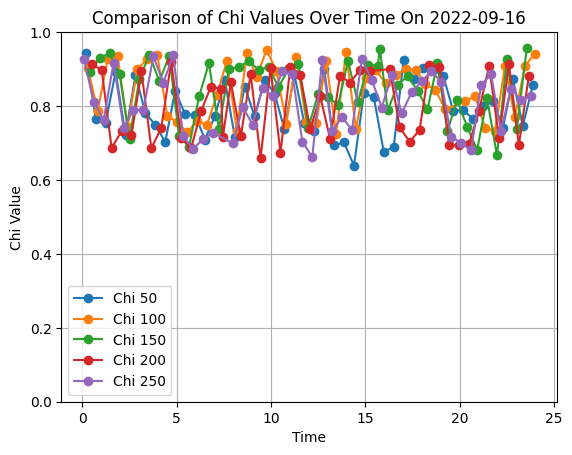

In [1153]:
plt.plot(df50.time, chi50, label='Chi 50', marker='o')
plt.plot(df100.time, chi100, label='Chi 100', marker='o')
plt.plot(df150.time, chi150, label='Chi 150', marker='o')
plt.plot(df200.time, chi200, label='Chi 200', marker='o')
plt.plot(df250.time, chi250, label='Chi 250', marker='o')
date_str = f"{date:8}"  # Convert to string for formatting
formatted_date = f"{date_str[0:4]}-{date_str[4:6]}-{date_str[6:8]}"  # YYYY-MM-DD
plt.title(f'Comparison of Chi Values Over Time On {formatted_date}')
plt.xlabel('Time')
plt.ylabel('Chi Value')
plt.ylim(0, 1)
plt.legend()
plt.grid(True)
plt.show()
# plt.plot(time50_i,chi50)

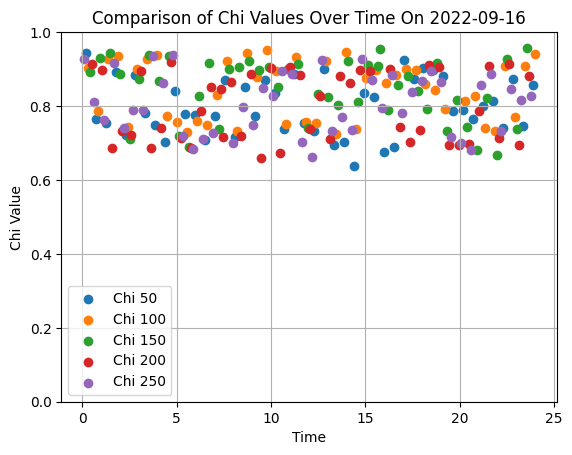

In [1154]:
plt.scatter(df50.time, chi50, label='Chi 50', marker='o')
plt.scatter(df100.time, chi100, label='Chi 100', marker='o')
plt.scatter(df150.time, chi150, label='Chi 150', marker='o')
plt.scatter(df200.time, chi200, label='Chi 200', marker='o')
plt.scatter(df250.time, chi250, label='Chi 250', marker='o')
date_str = f"{date:8}"  # Convert to string for formatting
formatted_date = f"{date_str[0:4]}-{date_str[4:6]}-{date_str[6:8]}"  # YYYY-MM-DD
plt.title(f'Comparison of Chi Values Over Time On {formatted_date}')
plt.xlabel('Time')
plt.ylabel('Chi Value')
plt.ylim(0, 1)
plt.legend()
plt.grid(True)
plt.show()

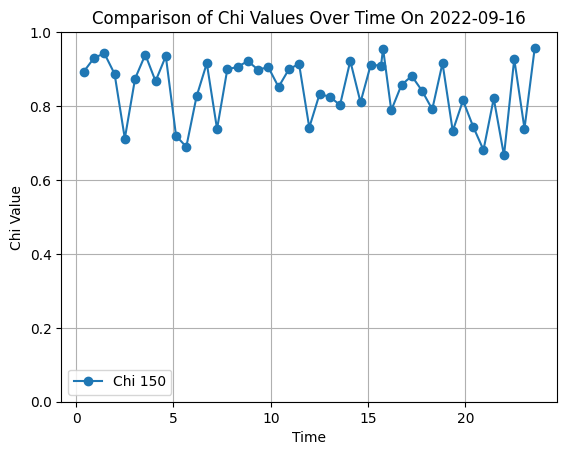

In [1155]:
plt.plot(df150.time, chi150, label='Chi 150', marker='o')
date_str = f"{date:8}"  # Convert to string for formatting
formatted_date = f"{date_str[0:4]}-{date_str[4:6]}-{date_str[6:8]}"  # YYYY-MM-DD
plt.title(f'Comparison of Chi Values Over Time On {formatted_date}')
plt.xlabel('Time')
plt.xlabel('Time')
plt.ylabel('Chi Value')
plt.ylim(0, 1)
plt.legend()
plt.grid(True)
plt.show()